# Cross correlate with a flask sim


In this notebook we will lens a CMB field with a kappa map generated from flask simulations. 
These simulations should reproduce the galaxy distribution and non-gaussian statistics. 

We will check how we can reconstruct the lensing potential lensed by this density field, and get the cross correlation signal. 

# Get the flask sim

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from plancklens.sims import phas, maps, cmbs, utils as maps_utils
from plancklens.utils import cli
import healpy as hp
import numpy as np
import os
from os.path import join as opj


import plancklens
from plancklens.filt import filt_simple, filt_util
from plancklens import utils
from plancklens import qest, qecl, qresp
from plancklens import nhl
from plancklens.n1 import n1
from plancklens.sims import planck2018_sims, phas, maps, cmbs, utils as maps_utils
from matplotlib import pyplot as plt


In [27]:
simdir = '/Users/louis/Library/Mobile Documents/com~apple~CloudDocs/falsk_sims_pauline'


fnsim = 'map-0.datf2z11.fits'

In [28]:
kmap = hp.read_map(opj(simdir, fnsim))

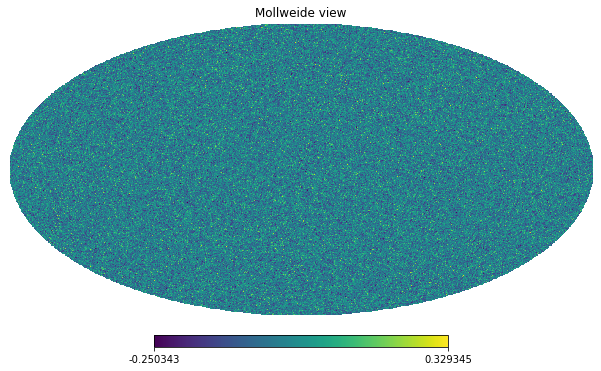

In [29]:
hp.mollview(kmap)

In [30]:
# Transform this kappa map into a phi map 

# TODO for students
# Tips, use the healpy functions map2alm, almm2map, almxfl and Alm.getlmax

def klm_to_plm(klm):
    lmax = hp.Alm.getlmax(klm.shape[0])
    fl = cli(np.arange(lmax+1) *np.arange(1, lmax+2) /2)
    plm = hp.almxfl(klm, fl)
    return plm


nside = hp.get_nside(kmap)
klm = hp.map2alm(kmap)
plm = klm_to_plm(klm)
pmap = hp.alm2map(plm, nside=nside)


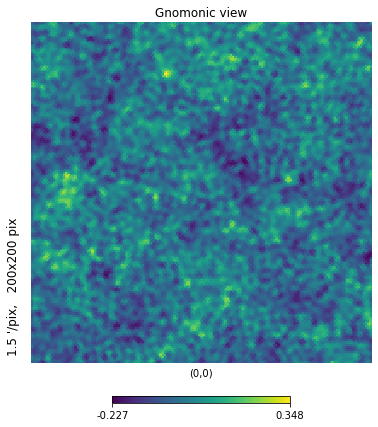

In [31]:
hp.gnomview(kmap)

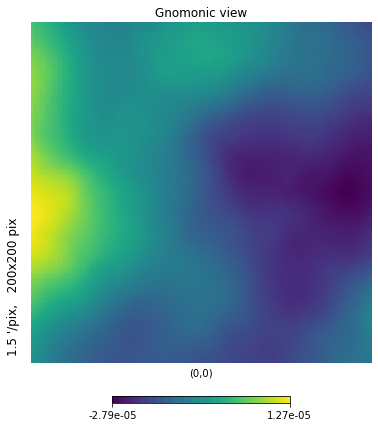

In [32]:
hp.gnomview(pmap)

[]

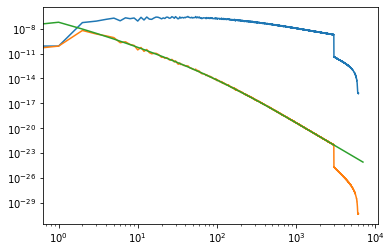

In [45]:
plt.plot(hp.alm2cl(klm))
plt.plot(hp.alm2cl(plm))
plt.plot(cl_unl['pp'])
plt.loglog()

# We can now lens the CMB with it 

This is done inside plancklens, using the lenspyx package. 

In [33]:
# TODO: follow the other notebook, but you can use the sims_cmb_len_fixed_phi class to generate the CMB 

In [34]:
os.environ['PLENS'] = opj(os.environ['HOME'], 'plens')
TEMP =  opj(os.environ['PLENS'], 'tutorial_flask')

In [35]:
nsims = 10  # Total number of simulations to generate.
lmax_sim = 4096 # lmax to produce the lensed cmb simulations

#--- definition of simulation and inverse-variance filtered simulation libraries:
lmax_ivf = 3000 
lmin_ivf = 2  # We will use in the QE only CMB modes between lmin_ivf and lmax_ivf
lmax_qlm = 4096 # We will calculate lensing estimates until multipole lmax_qlm.
nside = 2048 # Healpix resolution of the data and sims.
nlev_t = 5. # Filtering noise level in temperature (here also used for the noise simulations generation).
nlev_p = 5*np.sqrt(2) # Filtering noise level in polarization (here also used for the noise simulations generation).

beam_fwhm_amin = 2 # Beam full width half maximum in arcminutes


In [43]:
cls_path = opj(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')

# Fiducial unlensed and lensed power spectra used for the analysis:
cl_unl = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))

In [37]:
sims_libdir = opj(TEMP, 'len_alm')
sims = cmbs.sims_cmb_len_fixed_phi(sims_libdir, lmax_sim, cl_unl, plm=plm, lib_pha=None)

In [38]:
# Noise phases

libdir_pixphas = opj(TEMP, 'pix_phas_nside%s'%nside)
pix_phas = phas.pix_lib_phas(libdir_pixphas, 3, (hp.nside2npix(nside),))

In [39]:
# The maps are stored in another object 
# The transfer function is the beam of the instrument and the pixel window 

transf = hp.gauss_beam(beam_fwhm_amin / 60. / 180. * np.pi, lmax=lmax_ivf) * hp.pixwin(nside)[:lmax_ivf + 1]

cmbmaps = maps.cmb_maps_nlev(sims, transf, nlev_t, nlev_p, nside, pix_lib_phas=pix_phas)


In [40]:
lmax = hp.Alm.getlmax(klm.shape[0])
fl = cli(np.arange(lmax+1) *np.arange(1, lmax+2) /2)
plm = hp.almxfl(klm, fl)

BAND 0 in 16 :
resolve_poles: I have flipped 4 signs out of 6 pixels on south pole
input t1,t2 -0.151 5.902 in degrees
North 9.415 and South 9.481 buffers in amin
cell (theta,phi) in amin (0.948,0.542)
BAND 1 in 16 :
input t1,t2 5.426 11.499 in degrees
North 9.469 and South 9.513 buffers in amin
cell (theta,phi) in amin (0.951,0.526)
BAND 2 in 16 :
input t1,t2 11.030 17.125 in degrees
North 9.467 and South 9.527 buffers in amin
cell (theta,phi) in amin (0.955,0.388)
BAND 3 in 16 :
input t1,t2 16.608 22.758 in degrees
North 9.548 and South 9.539 buffers in amin
cell (theta,phi) in amin (0.964,0.510)
BAND 4 in 16 :
input t1,t2 22.257 28.364 in degrees
North 9.544 and South 9.531 buffers in amin
cell (theta,phi) in amin (0.957,0.626)
BAND 5 in 16 :
input t1,t2 27.882 34.007 in degrees
North 9.596 and South 9.529 buffers in amin
cell (theta,phi) in amin (0.960,0.737)
BAND 6 in 16 :
input t1,t2 33.482 39.634 in degrees
North 9.623 and South 9.583 buffers in amin
cell (theta,phi) in amin (0.

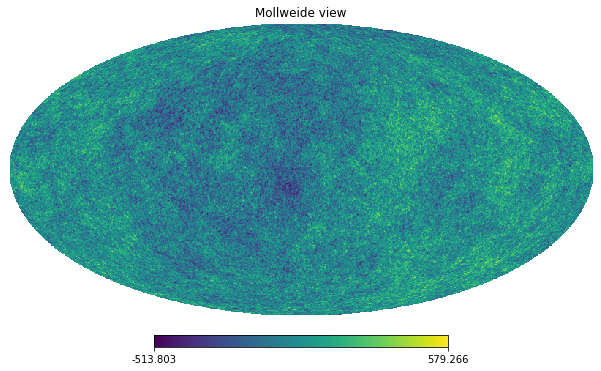

In [46]:
idx = 0
tmap = cmbmaps.get_sim_tmap(idx)
hp.mollview(tmap)

# Make the lensing reconstruction 

In [47]:
# --- We turn to the inverse-variance filtering library. In this file we use trivial isotropic filtering,
#     (independent T and Pol. filtering)
ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / transf) ** 2)
fel = utils.cli(cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
fbl = utils.cli(cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
ftl[:lmin_ivf] *= 0.
fel[:lmin_ivf] *= 0.
fbl[:lmin_ivf] *= 0.
#: Inverse CMB co-variance in T, E and B (neglecting TE coupling).

ivfs_libdir = opj(TEMP, 'ivfs')
ivfs = filt_simple.library_fullsky_sepTP(ivfs_libdir, cmbmaps, nside, transf, cl_len, ftl, fel, fbl, cache=True)
#: Inverse-variance filtering instance. Here a trivial isotropic inverse variance weighting.


In [48]:
qlms_dd = qest.library_sepTP(opj(TEMP, 'qlms'), ivfs, ivfs,   cl_len['te'], nside, lmax_qlm=lmax_qlm)


In [49]:
qlm = qlms_dd.get_sim_qlm('ptt', idx)


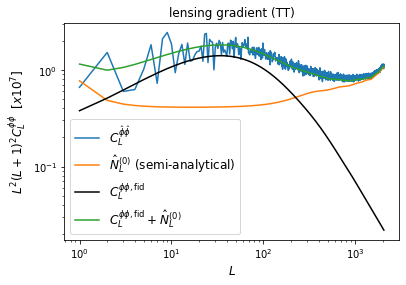

In [ ]:
# Lensing response according to the fiducial cosmology:
qresp = qresp_dd.get_response(qe_key, 'p')


# Estimator normalization is the inverse response:
qnorm = utils.cli(qresp)

# Semi-analytical realization-dependent Gaussian noise bias (of the unnormalized estimator):
nhl = nhl_dd.get_sim_nhl(idx, qe_key, qe_key)

# and we plot the normalized resulting spectra:
w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
ell = np.arange(2 if qe_key[0] == 'x' else 1, 2048)

plt.figure()
plt.title('lensing gradient (TT)' if qe_key[0] == 'p' else 'lensing curl (TT)')
label=r'$C_L^{\hat \phi \hat \phi}$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega}$'
plt.loglog(ell, hp.alm2cl(qlm)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label=label)
plt.loglog(ell, nhl[ell] * qnorm[ell] ** 2 * w(ell), label=r'$\hat N_L^{(0)}$ (semi-analytical)')
plt.loglog(ell, cl_unl['pp'][ell] *  w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
if  qe_key[0] == 'p':
    plt.loglog(ell, (cl_unl['pp'][ell] + nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)}$ ')
plt.xlabel('$L$', fontsize=12)
plt.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
plt.legend(fontsize=12, loc='lower left')